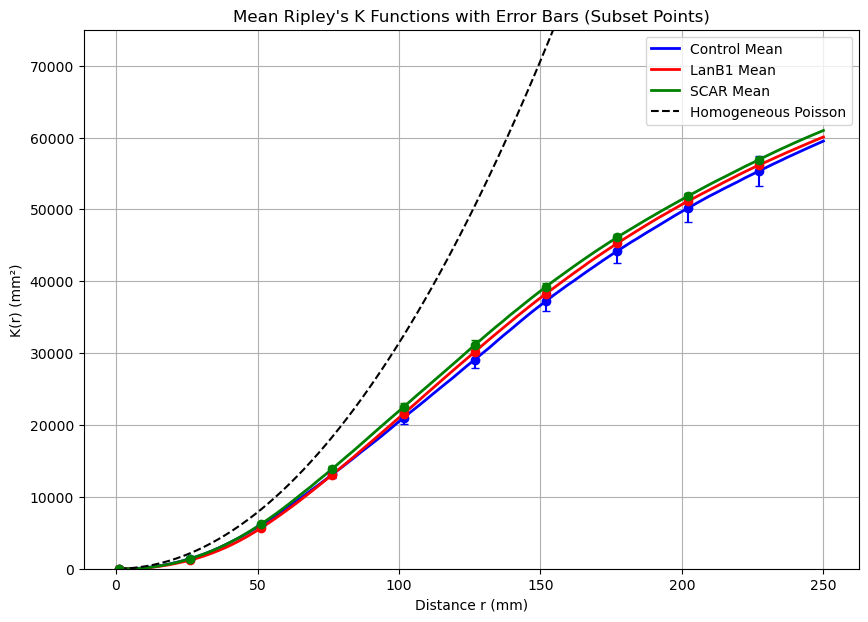

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Set random seed (if needed)
np.random.seed(42)

def compute_ripleys_k(coords, r_values, area):
    """
    Compute Ripley's K function for a set of coordinates.
    
    Parameters:
        coords (np.ndarray): Array of coordinates (n_points x dimensions).
        r_values (np.ndarray): Array of distances at which to evaluate K.
        area (float): The area of the study region.
        
    Returns:
        np.ndarray: Computed K function values for each r.
    """
    n = len(coords)
    if n == 0:
        return np.zeros_like(r_values)
    
    # Compute the pairwise distance matrix
    dist_matrix = distance_matrix(coords, coords)
    K_values = []
    
    for r in r_values:
        # Count pairs with distance <= r (exclude self-pairs)
        count = np.sum(dist_matrix <= r) - n
        # Ripley's K estimator: K(r) = (A/n^2) * (number of pairs with distance <= r)
        K_values.append((area * count) / (n ** 2))
    
    return np.array(K_values)

# Parameters for Ripley's K function
r_values = np.linspace(1, 250, 100)   # Distance range
area = 74606.5665                     # Study area (mm^2)
time_point = 399                      # The time slice to analyze

# Define file groups with corresponding file paths
files_by_group = {
    "Control": [
        "Control_130117.csv",
        "Control_140117.csv",
        "Control_191216.csv"
    ],
    "LanB1": [
        "LanB1_270317.csv",
        "LanB1_280317A.csv",
        "LanB1_280317B.csv"
    ],
    "SCAR": [
        "Scar_140117.csv",
        "Scar_151216.csv",
        "Scar_201216.csv"
    ]
}

# Define a color for each group
group_colors = {
    "Control": "blue",
    "LanB1": "red",
    "SCAR": "green"
}

# This dictionary will store all computed K functions for each group
group_K_values = {}

# Loop over each group and file, compute Ripley's K function
for group, file_list in files_by_group.items():
    group_K_values[group] = []  # store each file's K values
    
    for file_path in file_list:
        # Load the data
        data = pd.read_csv(file_path)
        # Filter data for the specified time point
        time_data = data[data['Time'] == time_point]
        # Extract coordinates (adjust column names if needed)
        coords = time_data[['Position X', 'Position Y', 'Position Z']].values
        
        if len(coords) == 0:
            print(f"{group} ({file_path}) has no data for Time == {time_point}")
            continue
        
        # Compute Ripley's K function for these coordinates
        K_values = compute_ripleys_k(coords, r_values, area)
        group_K_values[group].append(K_values)

plt.figure(figsize=(10, 7))

# Now compute and plot the mean function with error bars (only on a subset of points)
for group, k_list in group_K_values.items():
    color = group_colors.get(group, None)
    k_array = np.array(k_list)  # shape: (n_files, len(r_values))
    mean_K = k_array.mean(axis=0)
    stderr_K = k_array.std(axis=0) / np.sqrt(k_array.shape[0])  # standard error
    
    # Choose a subset of indices for error bars (e.g., every 10th point)
    subset_indices = np.arange(0, len(r_values), 10)
    
    # Plot the continuous mean curve
    plt.plot(r_values, mean_K, color=color, linestyle='-', linewidth=2, label=f'{group} Mean')
    # Overlay error bars on the subset of points
    plt.errorbar(r_values[subset_indices], mean_K[subset_indices],
                 yerr=stderr_K[subset_indices], color=color, marker='o', linestyle='None', capsize=3)


# Plot the theoretical Ripley's K for a homogeneous Poisson process (CSR)
plt.plot(r_values, np.pi * (r_values ** 2), 'k--', label="Homogeneous Poisson")

plt.xlabel("Distance r (mm)")
plt.ylabel("K(r) (mm²)")
plt.title("Mean Ripley's K Functions with Error Bars (Subset Points)")
plt.ylim([0, 75000])
plt.legend()
plt.grid(True)
plt.show()
